In [128]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')

import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
import pickle
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict

%matplotlib notebook



# Data
Here we have the initial pull of datasets include:
* game_df: this is game information for all games from 2008 to 2021 including unplayed games
* test_game_codes are going to be the game_codes of games in 2021 that are played (note: game_state_id 11 is finished game, 1 is Pre-Game)
* sim_game_codes are all games (played and unplayed) of 2021
* we split up all the game_codes into "played_game_codes" and "unplayed_game_codes"

#

In [2]:
game_df = pd.read_parquet(os.path.join(data_dir, 'game_data.parquet'))
game_df = game_df.sort_values(by='game_date', ascending=False).reset_index(drop=True)
odds_df = pd.read_parquet(os.path.join(data_dir, 'odds_data.parquet'))
odds_df = odds_df.drop_duplicates("game_code")
game_codes = game_df.game_code.values
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
played_game_codes = game_df.loc[game_df.game_state_id == 11, 'game_code'].values
unplayed_game_codes = game_df.loc[game_df.game_state_id != 11, 'game_code'].values
assert game_df.loc[~game_df.game_code.isin(unplayed_game_codes)].isna().sum().sum() == 0, 'Unexpected NaN values found in game data frame'
display(HTML(game_df.head(3).to_html(index=False)))
print('Games in sample: {0:d}'.format(game_codes.size))


game_code,game_date,home_team_id,away_team_id,season,home_team_abbrev,away_team_abbrev,week,game_type_id,home_score,away_score,status,game_state_id
2337728,2022-02-13 15:30:00,327,343,2021,Cin,LAR,23,3,20,23,Final,11
2337725,2022-01-30 15:30:00,343,359,2021,LAR,SF,21,7,20,17,Final,11
2337724,2022-01-30 14:00:00,339,327,2021,KC,Cin,21,7,24,27,Final,11


Games in sample: 3758


# Prior Data
Prior data is pulled from csv file and this will give us the inputs we need for the pre-game match predictions

In [3]:
prior_df = pd.read_csv(os.path.join(data_dir, 'game_priors.csv'))
display(HTML(prior_df.head(3).to_html(index=False)))

game_code,home_team_id,away_team_id,home_team_abbrev,away_team_abbrev,prior_home,prior_away,game_date
887191,329,347,Cle,Min,0.300686,0.696930,2009-09-13 13:00:00
887208,334,347,Det,Min,0.203864,0.795172,2009-09-20 13:00:00
887257,347,327,Min,Cin,0.677353,0.320797,2009-12-13 12:00:00


# Event Data
* Named event_df
* Is the play by play data from all games 2008 to 2021

# Input Features
Now that we have the datasets loaded we can load the features:
* prior_home: estimated probability of the home team winning at t=0
* prior_away: estimated probability of the away team winning at t=0
* home_team_has_ball: binary value for whether home team is in possession of the ball
* home_start_score: the score of the home team at the beginning of each play
* away_start_score: the score of the away team at the beginning of each play
* quarter: the current quarter/period the game is in (1-4 for all games, 5 if they are in the overtime period)
* play_start_time: numeric value of the time remaining in the quarter (900 at the beginning of the quarter, 0 at the end)
* yd_from_goal: the amount of yards between the line of scrimmage and the goal line for the team in possession of the ball
* down: the amount of downs that the team in possession of the ball has accumulate (1-4, down=-1 in plays that are not from scrimmage)
* ytg: the amount of yards between the current line of scrimmage and the first down line. (ytg=-1 in plays that are not from scrimmage)

# Target
remaining_exact_score: this is a numeric value for all the different combinations of remaining score (note: in this value sample, max_away_score=59 and max_home_score=62)
* for example if the current score is 17-24 (away_start_score=17 & home_start_score=24) and the final score is 27-30, then:
    *        remaining_exact_score = (27 - 17) + (62 + 1) * (30 - 24) = 422
* this ensures that all combinations of remaining exact scores are unique values


# Merged Table
full_df: the merged table of events_df and prior_df keeping only the input features and the target

In [61]:
events_df = pd.read_parquet(os.path.join(data_dir, 'event_data.parquet'))
events_df["half"] = round((events_df["quarter"] + 0.01) / 2)
events_df["home_timeout"] = np.where(((events_df["event_id"]==57)&(events_df["home_team_has_ball"]==1))|((events_df["event_id"]==58)&(events_df["home_team_has_ball"]==0)), 1, 0)
events_df["away_timeout"] = np.where(((events_df["event_id"]==57)&(events_df["home_team_has_ball"]==0))|((events_df["event_id"]==58)&(events_df["home_team_has_ball"]==1)), 1, 0)
events_df = events_df.sort_values(["game_code", "nevent"])
events_df["home_timeouts_remaining"] = np.clip(3 - events_df.groupby(["game_code", "half"])["home_timeout"].cumsum(), 0, 3)
events_df["away_timeouts_remaining"] = np.clip(3 - events_df.groupby(["game_code", "half"])["away_timeout"].cumsum(), 0, 3)

max_away_score = np.max(game_df["away_score"])
max_home_score = np.max(game_df["home_score"])

input_names = [
    # "prior_home",
    # "prior_away",
    "vegas_away_prediction",
    "vegas_home_prediction",
    # "cur_spread",
    # "cur_over_under",
    "home_team_has_ball",
    # "home_start_score",
    # "away_start_score",
    "current_score_diff", 
    "current_score_total",
    "quarter",
    "overtime",
    "play_start_time",
    "yd_from_goal",
    "from_scrimmage",
    "kick_off",
    "punt",
    "point_after_kick",
    "two_point_attempt",
    "field_goal_attempt",
    "down",
    "ytg",
    "home_timeouts_remaining",
    "away_timeouts_remaining",
]
output_name = 'remaining_exact_score'
events_df['remaining_exact_score'] = events_df["away_rest_of_game_score"] + \
                                     (max_away_score + 1) * events_df['home_rest_of_game_score']
events_df['mov_change'] = np.where(events_df["home_team_has_ball"], events_df["home_score_added"], -events_df["away_score_added"])
full_df = events_df.merge(prior_df, on="game_code", how="left").merge(odds_df, on="game_code", how="left")
full_df["cur_spread"].fillna((full_df["cur_spread"].mean()), inplace=True)
full_df["cur_over_under"].fillna((full_df["cur_over_under"].mean()), inplace=True)
full_df["vegas_away_prediction"] = full_df["cur_over_under"] / 2 + full_df["cur_spread"] * 0.5
full_df["vegas_home_prediction"] = full_df["cur_over_under"] / 2 - full_df["cur_spread"] * 0.5
full_df = full_df[full_df[input_names+[output_name]].notna().all(axis=1)]


In [62]:
# Show how the data frame looks like at the beginning and end of a game
sample_game_code = full_df.sample(1).iloc[0]['game_code']
sample_game_info = prior_df.loc[prior_df.game_code == sample_game_code, ['home_team_abbrev', 'away_team_abbrev', 'game_date']].iloc[0].tolist()
print('\nData sample for game: {0} v {1} ({2})'.format(*sample_game_info))
display(HTML(full_df.loc[full_df.game_code == sample_game_code][["game_code", "nevent"] + input_names]
             .iloc[list(range(0, 5)) + list(range(-5, 0))]
             .to_html(index=False)))


Data sample for game: Ten v Jax (2017-12-31 15:25:00)


game_code,nevent,vegas_away_prediction,vegas_home_prediction,home_team_has_ball,current_score_diff,current_score_total,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
1744960,1,18.75,21.25,1,0,0,1,0,900.0,65,0,1,0,0,0,0,0,-1,3,3
1744960,2,18.75,21.25,0,0,0,1,0,900.0,100,0,1,0,0,0,0,0,-1,3,3
1744960,3,18.75,21.25,0,0,0,1,0,894.0,78,1,0,0,0,0,0,1,10,3,3
1744960,4,18.75,21.25,0,0,0,1,0,866.0,73,1,0,0,0,0,0,2,5,3,3
1744960,5,18.75,21.25,0,0,0,1,0,861.0,73,1,0,0,0,0,0,3,5,3,3
1744960,215,18.75,21.25,0,5,25,4,0,24.0,82,0,1,0,0,0,0,0,-1,1,0
1744960,216,18.75,21.25,0,5,25,4,0,18.0,82,1,0,0,0,0,0,1,10,1,0
1744960,217,18.75,21.25,1,5,25,4,0,18.0,48,0,0,0,0,0,0,0,-1,1,0
1744960,218,18.75,21.25,1,5,25,4,0,10.0,47,1,0,0,0,0,0,1,10,1,0
1744960,219,18.75,21.25,1,5,25,4,0,0.0,48,0,0,0,0,0,0,2,-1,1,0


# Train/Test Data Split
Training and test dataframes are created (2009-2020 are training seasons and 2021 is the test season)
# Model
This is the stored model that predicts the probability of each remaining score combination at each point of the game

In [80]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)
output_name_score_change = "mov_change"

X_train = full_df.loc[(~mask_test)&(full_df.continuation==0), input_names]
y_train_score_change = full_df.loc[(~mask_test)&(full_df.continuation==0), output_name_score_change]
X_test = full_df.loc[mask_test&(full_df.continuation==0), input_names]
y_test_score_change = full_df.loc[mask_test&(full_df.continuation==0), output_name_score_change]


# rf_score_change = RandomForestClassifier(n_estimators=100, max_depth=10, verbose=10, n_jobs=-1).fit(X_train, y_train_score_change)
# pickle.dump(rf_score_change, open(os.path.join(root_dir, 'models/score_change_random_forest_100_10.p'), 'wb'))
rf_score_change = pickle.load(open(os.path.join(root_dir, "models/score_change_random_forest_100_10.p"), 'rb'))
score_change_columns = [
    "away_increase_6",
    "away_increase_3",
    "away_increase_2",
    "away_increase_1",
    "no_increase",
    "home_increase_1",
    "home_increase_2",
    "home_increase_3",
    "home_increase_6",
]

full_df[score_change_columns] = rf_score_change.predict_proba(full_df[input_names])
# clf = MLPClassifier(
#     hidden_layer_sizes=[10,5],
#     activation='relu',
#     solver='adam',
#     alpha=0.0001,  # L2 regularization parameter
#     learning_rate_init=0.001,
#     batch_size=128,
#     random_state=1,
#     max_iter=50, #50
#     early_stopping=True,
#     validation_fraction=0.1,
#     n_iter_no_change=5,
#     verbose=True).fit(X_train, y_train)
# pickle.dump(clf, open(os.path.join(root_dir, 'models/game_score_new_4.sav'), 'wb'))

# os.system('say "done"')


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.

In [125]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)
output_name_home_score = "home_rest_of_game_score"
output_name_away_score = "away_rest_of_game_score"

X_train = full_df.loc[(full_df.season_x<=2019)&(full_df.continuation==0), input_names+score_change_columns]
y_train_home_score_prediction = full_df.loc[(full_df.season_x<=2019)&(full_df.continuation==0), output_name_home_score]
y_train_away_score_prediction = full_df.loc[(full_df.season_x<=2019)&(full_df.continuation==0), output_name_away_score]
groups_train = full_df.loc[(full_df.season_x<=2019)&(full_df.continuation==0), "game_code"]
X_test = full_df.loc[(full_df.season_x==2021)&(full_df.continuation==0), input_names+score_change_columns]
y_test_home_score_prediction = full_df.loc[(full_df.season_x==2021)&(full_df.continuation==0), output_name_home_score]
y_test_away_score_prediction = full_df.loc[(full_df.season_x==2021)&(full_df.continuation==0), output_name_away_score]
groups_test = full_df.loc[(full_df.season_x==2021)&(full_df.continuation==0), "game_code"]
X_val = full_df.loc[(full_df.season_x==2020)&(full_df.continuation==0), input_names+score_change_columns]
y_val_home_score_prediction = full_df.loc[(full_df.season_x==2020)&(full_df.continuation==0), output_name_home_score]
y_val_away_score_prediction = full_df.loc[(full_df.season_x==2020)&(full_df.continuation==0), output_name_away_score]
groups_val = full_df.loc[(full_df.season_x==2010)&(full_df.continuation==0), "game_code"]

categoricals = [
    'home_team_has_ball',
    'overtime',
    'from_scrimmage',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    'down',
]
COMPUTE_PARAMS = {"thread_count": -1}
param_spaces={
    "learning_rate":np.linspace(0.01,0.1),
    "min_child_samples":range(1,1000,100),
    "subsample":np.linspace(0.333,1),
    "random_strength":np.linspace(1,100),
    "l2_leaf_reg":np.linspace(0.1,100),
    "max_depth":range(2,16)}

# param_spaces={
#     'random_strength': 39.38775510204081,
#     'early_stopping_rounds': 5,
#     'min_child_samples': 1,
#     'max_depth': 12,
#     'learning_rate': 0.05591836734693878,
#     'l2_leaf_reg': 55.146938775510215,
#     **COMPUTE_PARAMS}
import catboost as cb
param_spaces = {
    'subsample': 0.6324693877551021,
    'random_strength': 100.0,
    'min_child_samples': 301,
    'max_depth': 11,
    'learning_rate': 0.02836734693877551,
    'l2_leaf_reg': 49.030612244897966
 }
curr_val_pool =cb.Pool(
        data=X_val,
        label=y_val_away_score_prediction,
        cat_features=categoricals,
        feature_names=input_names + score_change_columns
    )

cv=GroupKFold(n_splits=3)
#param_distributions={"alpha":np.linspace(3200,4500,1000)}
reg=CatBoostRegressor(early_stopping_rounds=5,cat_features=categoricals,n_estimators=10000)#, devices="0:1",bootstrap_type= "Poisson", max_bin=32,thread_count=1,objective="RMSE")
search=RandomizedSearchCV(reg,param_spaces,cv=cv,random_state=42,n_iter=10,n_jobs=1,verbose=10)
search.fit(X_train,y_train_away_score_prediction, eval_set=curr_val_pool,groups=groups_train)
# cb_score_prediction_home = CatBoostRegressor(cat_features=categoricals, verbose=1, **param_spaces).fit(X_train, y_train_home_score_prediction)
# cb_score_prediction_away = CatBoostRegressor(cat_features=categoricals, verbose=1, **param_spaces).fit(X_train, y_train_away_score_prediction)


# rf_score_change = RandomForestClassifier(n_estimators=100, max_depth=10, verbose=10, n_jobs=-1).fit(X_train, y_train_score_change)
# rf_score_prediction_home = RandomForestRegressor(n_estimators=50, max_depth=12, verbose=5, n_jobs=-1).fit(X_train, y_train_home_score_prediction)
# rf_score_prediction_away = RandomForestRegressor(n_estimators=50, max_depth=12, verbose=5, n_jobs=-1).fit(X_train, y_train_away_score_prediction)
# cb_score_prediction_home = CatBoostRegressor(n_estimators=50, max_depth=12, verbose=5, n_jobs=-1).fit(X_train, y_train_home_score_prediction)

# pickle.dump(rf_score_change, open(os.path.join(root_dir, 'models/score_change_random_forest_100_10.p'), 'wb'))

# clf = MLPClassifier(
#     hidden_layer_sizes=[10,5],
#     activation='relu',
#     solver='adam',
#     alpha=0.0001,  # L2 regularization parameter
#     learning_rate_init=0.001,
#     batch_size=128,
#     random_state=1,
#     max_iter=50, #50
#     early_stopping=True,
#     validation_fraction=0.1,
#     n_iter_no_change=5,
#     verbose=True).fit(X_train, y_train)
# pickle.dump(clf, open(os.path.join(root_dir, 'models/game_score_new_4.sav'), 'wb'))

os.system('say "done"')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START l2_leaf_reg=61.263265306122456, learning_rate=0.06142857142857144, max_depth=5, min_child_samples=801, random_strength=29.285714285714285, subsample=0.5780204081632654


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 9.2751525	test: 10.1412109	best: 10.1412109 (0)	total: 48.4ms	remaining: 8m 4s
1:	learn: 9.0731070	test: 9.9266217	best: 9.9266217 (1)	total: 118ms	remaining: 9m 51s
2:	learn: 8.8807154	test: 9.7197457	best: 9.7197457 (2)	total: 170ms	remaining: 9m 27s
3:	learn: 8.7225631	test: 9.5507917	best: 9.5507917 (3)	total: 216ms	remaining: 9m
4:	learn: 8.5521417	test: 9.3652976	best: 9.3652976 (4)	total: 262ms	remaining: 8m 43s
5:	learn: 8.4246085	test: 9.2244130	best: 9.2244130 (5)	total: 311ms	remaining: 8m 38s
6:	learn: 8.3111012	test: 9.0978381	best: 9.0978381 (6)	total: 361ms	remaining: 8m 35s
7:	learn: 8.1845896	test: 8.9572963	best: 8.9572963 (7)	total: 406ms	remaining: 8m 26s
8:	learn: 8.0880633	test: 8.8457035	best: 8.8457035 (8)	total: 450ms	remaining: 8m 19s
9:	learn: 7.9873526	test: 8.7243789	best: 8.7243789 (9)	total: 570ms	remaining: 9m 29s
10:	learn: 7.9200131	test: 8.6295700	best: 8.6295700 (10)	total: 632ms	remaining: 9m 34s
11:	learn: 7.8432266	test: 8.5442704	best: 

0

In [147]:
param_spaces = {
    'subsample': [0.6324693877551021],
    'random_strength': [100.0],
    'min_child_samples': [301],
    'max_depth': [11],
    'learning_rate': [0.02836734693877551],
    'l2_leaf_reg': [49.030612244897966]
 }
curr_val_pool =cb.Pool(
        data=X_val,
        label=y_val_away_score_prediction,
        cat_features=categoricals,
        feature_names=input_names + score_change_columns
    )

cv=GroupKFold(n_splits=3)
#param_distributions={"alpha":np.linspace(3200,4500,1000)}
reg=CatBoostRegressor(early_stopping_rounds=5,cat_features=categoricals,n_estimators=10000)#, devices="0:1",bootstrap_type= "Poisson", max_bin=32,thread_count=1,objective="RMSE")
search_home=RandomizedSearchCV(reg,param_spaces,cv=cv,random_state=42,n_iter=10,n_jobs=1,verbose=10)
search_home.fit(X_train,y_train_home_score_prediction, eval_set=curr_val_pool,groups=groups_train)


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START l2_leaf_reg=49.030612244897966, learning_rate=0.02836734693877551, max_depth=11, min_child_samples=301, random_strength=100.0, subsample=0.6324693877551021
0:	learn: 9.9781196	test: 10.2031737	best: 10.2031737 (0)	total: 496ms	remaining: 1h 22m 43s
1:	learn: 9.8951603	test: 10.1208471	best: 10.1208471 (1)	total: 865ms	remaining: 1h 12m 5s
2:	learn: 9.7860246	test: 10.0085106	best: 10.0085106 (2)	total: 1.19s	remaining: 1h 6m 11s
3:	learn: 9.6884276	test: 9.9167438	best: 9.9167438 (3)	total: 1.43s	remaining: 59m 45s
4:	learn: 9.5746500	test: 9.8004679	best: 9.8004679 (4)	total: 2.04s	remaining: 1h 8m 4s
5:	learn: 9.4800250	test: 9.7032478	best: 9.7032478 (5)	total: 2.12s	remaining: 58m 50s
6:	learn: 9.4079129	test: 9.6325024	best: 9.6325024 (6)	total: 2.45s	remaining: 58m 22s
7:	learn: 9.3105185	test: 9.5345208	best: 9.5345208 (7)	total: 2.63s	remaining: 54m 48s
8:	learn: 9.2149006	test: 9.4503208	best: 9.450

RandomizedSearchCV(cv=GroupKFold(n_splits=3),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fd47e8ebeb0>,
                   n_jobs=1,
                   param_distributions={'l2_leaf_reg': [49.030612244897966],
                                        'learning_rate': [0.02836734693877551],
                                        'max_depth': [11],
                                        'min_child_samples': [301],
                                        'random_strength': [100.0],
                                        'subsample': [0.6324693877551021]},
                   random_state=42, verbose=10)

In [151]:
big_cv = GroupKFold(n_splits=5)
final_model_home = cb.CatBoostRegressor(n_estimators=search_home.best_estimator_.tree_count_, **search_home.best_params_,cat_features=categoricals,verbose=1)
full_df["xhome_score_rest_of_game_cb"] = cross_val_predict(final_model_home,full_df[input_names+score_change_columns],full_df[output_name_away_score],groups=full_df["game_code"],cv=big_cv,verbose=1,n_jobs=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


0:	learn: 9.5411083	total: 643ms	remaining: 50.2s
1:	learn: 9.4543898	total: 1.02s	remaining: 39.1s
0:	learn: 9.4517226	total: 984ms	remaining: 1m 16s
0:	learn: 9.5046959	total: 838ms	remaining: 1m 5s
0:	learn: 9.3850784	total: 924ms	remaining: 1m 12s
0:	learn: 9.4532360	total: 1.27s	remaining: 1m 39s
2:	learn: 9.3518488	total: 1.97s	remaining: 49.9s
1:	learn: 9.3938256	total: 2.02s	remaining: 1m 17s
1:	learn: 9.3677889	total: 1.66s	remaining: 1m 3s
1:	learn: 9.3972633	total: 1.99s	remaining: 1m 16s
1:	learn: 9.2798219	total: 2.09s	remaining: 1m 20s
3:	learn: 9.2724652	total: 2.78s	remaining: 52.2s
2:	learn: 9.2931347	total: 2.84s	remaining: 1m 11s
2:	learn: 9.2669411	total: 2.44s	remaining: 1m 1s
2:	learn: 9.3004601	total: 2.76s	remaining: 1m 9s
2:	learn: 9.1853482	total: 2.89s	remaining: 1m 13s
4:	learn: 9.1848132	total: 3.67s	remaining: 54.4s
3:	learn: 9.1911171	total: 3.71s	remaining: 1m 9s
3:	learn: 9.1885341	total: 3.25s	remaining: 1m
3:	learn: 9.2088301	total: 3.56s	remaining: 1

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.1min finished


In [132]:
search.best_estimator_.tree_count_

377

In [152]:
big_cv = GroupKFold(n_splits=5)
final_model = cb.CatBoostRegressor(n_estimators=search.best_estimator_.tree_count_, **search.best_params_,cat_features=categoricals,verbose=1)
full_df["xaway_score_rest_of_game_cb"] = cross_val_predict(final_model,full_df[input_names+score_change_columns],full_df[output_name_away_score],groups=full_df["game_code"],cv=big_cv,verbose=1,n_jobs=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


0:	learn: 9.3874465	total: 780ms	remaining: 4m 53s
0:	learn: 9.5355716	total: 763ms	remaining: 4m 47s
0:	learn: 9.5396485	total: 1.08s	remaining: 6m 46s
0:	learn: 9.4499630	total: 1.2s	remaining: 7m 32s
0:	learn: 9.4519587	total: 1.2s	remaining: 7m 31s
1:	learn: 9.3164133	total: 1.84s	remaining: 5m 45s
1:	learn: 9.3511855	total: 1.77s	remaining: 5m 31s
1:	learn: 9.4429953	total: 2.16s	remaining: 6m 45s
1:	learn: 9.4404079	total: 2.15s	remaining: 6m 42s
2:	learn: 9.2927166	total: 2.2s	remaining: 4m 34s
1:	learn: 9.3570614	total: 2.33s	remaining: 7m 16s
3:	learn: 9.2072693	total: 2.56s	remaining: 3m 59s
2:	learn: 9.2182141	total: 3.25s	remaining: 6m 45s
2:	learn: 9.3444201	total: 3.57s	remaining: 7m 24s
2:	learn: 9.3398456	total: 3.52s	remaining: 7m 18s
4:	learn: 9.1231067	total: 3.57s	remaining: 4m 25s
2:	learn: 9.2618489	total: 3.77s	remaining: 7m 49s
3:	learn: 9.1522176	total: 4.38s	remaining: 6m 48s
5:	learn: 9.0492440	total: 4.06s	remaining: 4m 11s
3:	learn: 9.2757492	total: 4.74s	r

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.1min remaining:  9.2min


372:	learn: 6.6321311	total: 5m 59s	remaining: 3.85s
373:	learn: 6.6321311	total: 5m 59s	remaining: 2.88s
361:	learn: 6.7026257	total: 5m 58s	remaining: 14.9s
374:	learn: 6.6318404	total: 5m 59s	remaining: 1.92s
362:	learn: 6.7024916	total: 5m 59s	remaining: 13.9s
363:	learn: 6.7024674	total: 6m	remaining: 12.9s
375:	learn: 6.6310474	total: 6m	remaining: 959ms
364:	learn: 6.7022544	total: 6m	remaining: 11.9s
376:	learn: 6.6309370	total: 6m 1s	remaining: 0us
365:	learn: 6.7015280	total: 6m 1s	remaining: 10.9s
366:	learn: 6.7014435	total: 6m 1s	remaining: 9.85s
367:	learn: 6.7012724	total: 6m 1s	remaining: 8.85s
368:	learn: 6.7009922	total: 6m 2s	remaining: 7.86s
369:	learn: 6.7008540	total: 6m 2s	remaining: 6.86s
370:	learn: 6.7008462	total: 6m 2s	remaining: 5.87s
371:	learn: 6.7004838	total: 6m 2s	remaining: 4.88s
372:	learn: 6.7004757	total: 6m 2s	remaining: 3.89s
373:	learn: 6.7002818	total: 6m 3s	remaining: 2.91s
374:	learn: 6.6997972	total: 6m 3s	remaining: 1.94s
375:	learn: 6.6995

[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.2min finished


In [145]:
search
# pickle.dump(rf_score_change, open(os.path.join(root_dir, 'models/score_change_random_forest_100_10.p'), 'wb'))
pickle.dump(search, open(os.path.join(root_dir, 'models/search_cv_away_score.p'), 'wb'))
pickle.dump(reg, open(os.path.join(root_dir, 'models/cb_away_score.p'), 'wb'))
pickle.dump(final_model, open(os.path.join(root_dir, 'models/final_away_score.p'), 'wb'))

In [114]:
# rf_score_prediction_away.verbose = 0
# rf_score_prediction_home.verbose = 0
full_df["xaway_score_rest_of_game"] = cb_score_prediction_away.predict(full_df[input_names+score_change_columns])
full_df["xhome_score_rest_of_game"] = cb_score_prediction_home.predict(full_df[input_names+score_change_columns])
full_df["xaway_score"] = full_df["xaway_score_rest_of_game"] + full_df["away_start_score"]
full_df["xhome_score"] = full_df["xhome_score_rest_of_game"] + full_df["home_start_score"]
%matplotlib inline


In [137]:
super_bowl = full_df[full_df["game_code"] == 1321887]
super_bowl.to_clipboard()

In [110]:
example_score = [[ 13.5,  41.,   1.,   0.,   0.,   1.,   0., 900.,  65.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,  -1.,   3.,   3.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.]]
print(rf_score_prediction_away.predict(example_score))
print(rf_score_prediction_home.predict(example_score))

[32.72720561]
[34.14345595]


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


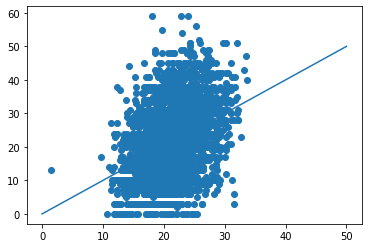

In [139]:
%matplotlib inline
beginning_of_game = full_df[full_df["nevent"]==1]
plt.scatter(beginning_of_game["vegas_away_prediction"], beginning_of_game["xaway_score_rest_of_game_cb"])
plt.plot([0, 50], [0, 50])

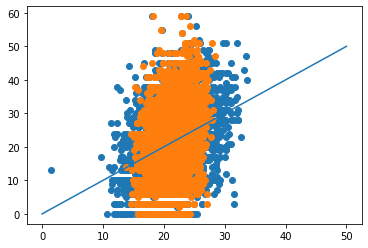

In [141]:
plt.scatter(beginning_of_game["vegas_away_prediction"], beginning_of_game["away_rest_of_game_score"])
plt.scatter(beginning_of_game["xaway_score_rest_of_game_cb"], beginning_of_game["away_rest_of_game_score"])
plt.plot([0, 50], [0, 50])

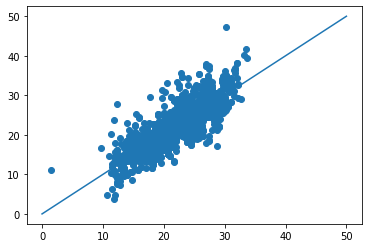

In [117]:
beginning_of_game = full_df[full_df["nevent"]==1]
plt.scatter(beginning_of_game["vegas_away_prediction"], beginning_of_game["xaway_score_rest_of_game"])
plt.plot([0, 50], [0, 50])

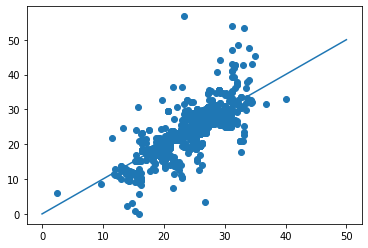

In [75]:
plt.scatter(beginning_of_game["vegas_home_prediction"], beginning_of_game["xhome_score_rest_of_game"])
plt.plot([0, 50], [0, 50])

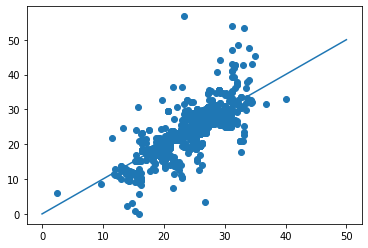

In [76]:
plt.scatter(beginning_of_game["vegas_home_prediction"], beginning_of_game["xhome_score_rest_of_game"])
plt.plot([0, 50], [0, 50])

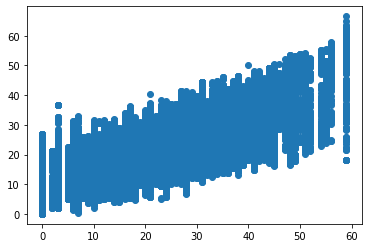

In [77]:
%matplotlib inline
plt.scatter(full_df["away_final_score"], full_df["xaway_score"])

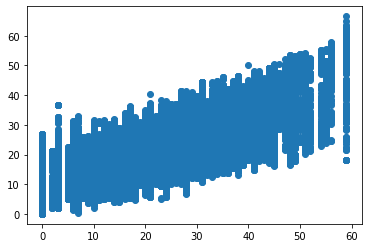

In [78]:
%matplotlib inline
plt.scatter(full_df["away_final_score"], full_df["xaway_score"])

In [79]:
pd.DataFrame(rf_score_prediction_away.feature_importances_, index=rf_score_prediction_away.feature_names_in_)

,0
vegas_away_prediction,0.111847
vegas_home_prediction,0.041968
home_team_has_ball,0.007634
current_score_diff,0.023919
current_score_total,0.011609
quarter,0.730745
overtime,0.000436
play_start_time,0.050581
yd_from_goal,0.012666
from_scrimmage,0.000030


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.3s finished


In [51]:
X_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), input_names+score_change_columns]
y_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), output_name]
X_test_rf = full_df.loc[mask_test&(full_df.continuation==0), input_names + score_change_columns].values
y_test_rf = full_df.loc[mask_test&(full_df.continuation==0), output_name].values

rf = pickle.load(open(os.path.join(root_dir, "models/game_score_random_forest_100_10_new_features.p"), 'rb'))
# rf = RandomForestClassifier(n_estimators=100, max_depth=10, verbose=100, n_jobs=-1).fit(X_train_rf, y_train_rf)
# pickle.dump(rf, open(os.path.join(root_dir, 'models/game_score_random_forest_100_10_new_features.p'), 'wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100building tree 5 of 100building tree 6 of 100


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.7s

building tree 10 of 100
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.4s
building tree 11 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.6s

building tree 12 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.0s

building tree 13 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.5s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   29.4s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   30.2s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.3s

building tree 17 of 100[Parallel(n_jobs=-1)]: Do

In [9]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)

X_train = full_df.loc[~mask_test, input_names]
y_train = full_df.loc[~mask_test, output_name]
X_test = full_df.loc[mask_test, input_names].values
y_test = full_df.loc[mask_test, output_name].values
n_categories = (max_home_score + 1) * (max_away_score + 1)




# clf = MLPClassifier(
#     hidden_layer_sizes=[10,5],
#     activation='relu',
#     solver='adam',
#     alpha=0.0001,  # L2 regularization parameter
#     learning_rate_init=0.001,
#     batch_size=128,
#     random_state=1,
#     max_iter=50, #50
#     early_stopping=True,
#     validation_fraction=0.1,
#     n_iter_no_change=5,
#     verbose=True).fit(X_train, y_train)
# pickle.dump(clf, open(os.path.join(root_dir, 'models/game_score_new_4.sav'), 'wb'))

# os.system('say "done"')


['cur_spread',
 'cur_over_under',
 'home_team_has_ball',
 'current_score_diff',
 'current_score_total',
 'quarter',
 'overtime',
 'play_start_time',
 'yd_from_goal',
 'from_scrimmage',
 'kick_off',
 'punt',
 'point_after_kick',
 'two_point_attempt',
 'field_goal_attempt',
 'down',
 'ytg',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'away_increase_6',
 'away_increase_3',
 'away_increase_2',
 'away_increase_1',
 'no_increase',
 'home_increase_1',
 'home_increase_2',
 'home_increase_3',
 'home_increase_6']

In [58]:
clf = pickle.load(open(os.path.join(root_dir, "models/game_score_new_4.sav"), 'rb'))
clf_old = pickle.load(open(os.path.join(root_dir, "models/game_score.sav"), 'rb'))
clf.feature_names_in_.toli

c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array(['prior_home', 'prior_away', 'home_team_has_ball',
       'home_start_score', 'away_start_score', 'quarter', 'overtime',
       'play_start_time', 'yd_from_goal', 'from_scrimmage', 'kick_off',
       'punt', 'point_after_kick', 'two_point_attempt',
       'field_goal_attempt', 'down', 'ytg', 'home_timeouts_remaining',
       'away_timeouts_remaining'], dtype=object)

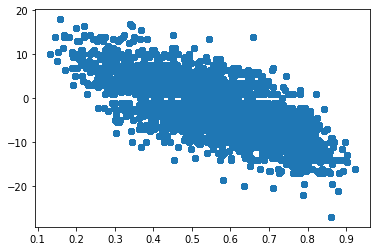

In [61]:
%matplotlib inline
plt.scatter(full_df["prior_home"], full_df["cur_spread"])

In [11]:
import time
def get_model_outputs(model, input_data, running_scores):
    start_time = time.time()
    raw_output = model.predict_proba(input_data)
    # Exact score outputs    
    score_probs = np.zeros((input_data.shape[0], n_categories))
    score_probs[:, model.classes_] = raw_output
    # 1X2 prediction & team score outputs
    outcome_probs = np.zeros((input_data.shape[0], 3))
    home_score_probs = np.zeros((input_data.shape[0], max_home_score + 1))
    away_score_probs = np.zeros((input_data.shape[0], max_away_score + 1))
    for home_score in range(max_home_score + 1):
        ft_home_score = home_score + running_scores[:, 0]
        for away_score in range(max_away_score + 1):            
            # print(home_score, "-", away_score)
            ft_away_score = away_score + running_scores[:, 1]
            remaining_prob = score_probs[:, away_score + (max_away_score + 1) * home_score]
            # 1X2 - Home win
            outcome_probs[:, 0] = np.where(ft_home_score > ft_away_score,
                                           outcome_probs[:, 0] + remaining_prob,
                                           outcome_probs[:, 0])
            # 1X2 - Draw
            outcome_probs[:, 1] = np.where(ft_home_score == ft_away_score,
                                           outcome_probs[:, 1] + remaining_prob,
                                           outcome_probs[:, 1])
            # 1X2 - Away win
            outcome_probs[:, 2] = np.where(ft_home_score < ft_away_score,
                                           outcome_probs[:, 2] + remaining_prob,
                                           outcome_probs[:, 2])
            # Team scores
            home_score_probs[:, home_score] += remaining_prob
            away_score_probs[:, away_score] += remaining_prob
    return {
        'remaining_score': score_probs,
        'home_score': home_score_probs,
        'away_score': away_score_probs,
        'ft_outcome': outcome_probs
    }

## Usage example
Below is just a little bit of code that shows how the input and output data looks like for a few samples in a random game:

In [12]:
example_game_code = np.random.choice(test_game_codes)
example_indices = [0, 1, -2, -1]
example_input = full_df.sort_values("nevent").loc[full_df.game_code == example_game_code, input_names].values[example_indices]
full_df = full_df.sort_values(["game_code", "nevent"], ascending=True)
example_running_score = full_df.loc[full_df.game_code == example_game_code,
                                    ['home_start_score', 'away_start_score']].values[example_indices]
example_output = get_model_outputs(clf, example_input, example_running_score)
print('\nExample input data:')
display(HTML(pd.DataFrame(data=example_input, columns=input_names).to_html(index=False)))

# print('\nExample outputs (exact score):')
# print(example_output['remaining_score'][0][0:10])
# print(example_output['remaining_score'][0][10:20])
# print(example_output['remaining_score'][0][20:30])

print('\nExample outputs (home team score):')
display(HTML(pd.DataFrame(data=example_output['home_score'], columns=np.arange(max_home_score + 1)).to_html(index=False)))

print('\nExample outputs (away team score):')
display(HTML(pd.DataFrame(data=example_output['away_score'], columns=np.arange(max_away_score + 1)).to_html(index=False)))

print('\nExample outputs (1X2):')
display(HTML(pd.DataFrame(data=example_output['ft_outcome'], columns=['home win', 'draw', 'away win']).to_html(index=False)))

c:\Users\lucas\OneDrive\Documents\GitHub\nfl-live-win-probability\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Example input data:


prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,overtime,play_start_time,yd_from_goal,from_scrimmage,kick_off,punt,point_after_kick,two_point_attempt,field_goal_attempt,down,ytg,home_timeouts_remaining,away_timeouts_remaining
0.521872,0.47262,1.0,0.0,0.0,1.0,0.0,900.0,65.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,3.0
0.521872,0.47262,0.0,0.0,0.0,1.0,0.0,900.0,92.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,3.0
0.521872,0.47262,0.0,7.0,22.0,4.0,0.0,9.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,3.0
0.521872,0.47262,0.0,7.0,22.0,4.0,0.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,3.0



Example outputs (home team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0.009299,0.000006,0.000258,0.015628,1.835141e-05,0.000620,0.017926,0.020330,0.002319,0.012087,0.040055,0.004432,0.011235,0.042203,0.029243,0.011038,0.039037,0.067118,0.009894,2.410061e-02,0.070928,0.037157,0.015781,4.732962e-02,0.068764,0.010514,2.944098e-02,5.490783e-02,2.867547e-02,1.236582e-02,3.304905e-02,4.746305e-02,8.045290e-03,1.555245e-02,2.788981e-02,1.861617e-02,8.012730e-03,1.387431e-02,2.585552e-02,3.479759e-03,6.610927e-03,8.659825e-03,8.514496e-03,4.648549e-03,4.130129e-03,1.111238e-02,1.771064e-03,2.447184e-03,4.677998e-03,4.822364e-03,2.692630e-04,1.717037e-03,1.782822e-03,5.350019e-04,5.136974e-04,1.579461e-03,5.157834e-04,1.026871e-04,2.658023e-04,5.487982e-04,2.109816e-10,0.0,2.254235e-04
0.009810,0.000009,0.000291,0.016151,2.733538e-05,0.000701,0.018378,0.021203,0.002634,0.012634,0.040303,0.004893,0.011543,0.041890,0.029969,0.011722,0.038689,0.065834,0.010613,2.416551e-02,0.068160,0.037381,0.016348,4.577567e-02,0.066226,0.011223,2.899624e-02,5.267204e-02,2.922165e-02,1.274996e-02,3.245804e-02,4.595462e-02,8.492712e-03,1.596651e-02,2.764300e-02,1.902708e-02,8.308912e-03,1.433891e-02,2.574239e-02,3.777478e-03,6.890904e-03,8.998140e-03,8.758774e-03,4.884787e-03,4.384123e-03,1.120002e-02,1.906701e-03,2.520774e-03,4.895535e-03,4.980571e-03,2.968309e-04,1.856029e-03,1.931497e-03,5.696206e-04,5.540901e-04,1.668842e-03,5.585219e-04,1.138381e-04,2.816872e-04,5.835037e-04,2.178525e-10,0.0,2.431598e-04
0.946434,0.000162,0.001977,0.007142,4.367532e-09,0.000022,0.005724,0.026306,0.009929,0.000103,0.000621,0.000366,0.000014,0.000240,0.000684,0.000161,0.000015,0.000027,0.000043,5.738479e-07,0.000005,0.000011,0.000005,8.251067e-07,0.000004,0.000002,5.418387e-08,1.072368e-07,7.211253e-07,1.555196e-07,6.999231e-08,1.000347e-08,9.201624e-08,2.132639e-09,2.943906e-07,2.330418e-08,3.788621e-07,3.992223e-11,1.561512e-09,3.223278e-09,8.736600e-11,6.439774e-12,2.315232e-10,2.961635e-12,1.439920e-12,2.417232e-12,3.611207e-13,5.630025e-19,3.889584e-09,8.886182e-13,5.937460e-17,6.402107e-12,2.353995e-12,2.209313e-18,2.033689e-29,1.173379e-32,8.477665e-18,3.677677e-12,6.963872e-31,2.529445e-12,2.331782e-12,0.0,2.529214e-12
0.943732,0.000172,0.002080,0.007377,4.923178e-09,0.000024,0.005978,0.027540,0.010591,0.000112,0.000667,0.000399,0.000016,0.000261,0.000742,0.000178,0.000017,0.000030,0.000050,6.579554e-07,0.000006,0.000013,0.000006,9.479742e-07,0.000005,0.000002,6.383003e-08,1.259578e-07,8.250173e-07,1.806619e-07,8.219993e-08,1.176858e-08,1.082694e-07,2.761505e-09,3.710170e-07,2.857672e-08,4.460890e-07,4.826528e-11,1.869854e-09,3.945163e-09,1.138561e-10,8.063941e-12,2.921284e-10,3.781640e-12,2.040139e-12,2.677955e-12,4.800643e-13,7.734757e-19,4.651162e-09,1.232728e-12,7.834054e-17,7.764537e-12,2.612976e-12,3.024245e-18,3.278345e-29,1.974682e-32,1.306672e-17,4.452639e-12,1.189151e-30,2.801165e-12,2.581392e-12,0.0,3.053210e-12



Example outputs (away team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0.015702,0.000023,0.000980,0.021332,0.000072,0.001275,0.021486,0.033931,0.002821,0.019587,0.062016,0.003409,0.013751,0.052474,0.040693,0.009391,0.038220,0.086254,0.010737,0.019359,0.068137,0.035822,1.196510e-02,5.190182e-02,6.221648e-02,1.132105e-02,2.457042e-02,4.982841e-02,2.528144e-02,8.100008e-03,2.539562e-02,3.498096e-02,6.978288e-03,1.473612e-02,2.497080e-02,1.385221e-02,6.338212e-03,1.337724e-02,1.495906e-02,3.237243e-03,3.919894e-03,1.257504e-02,6.218789e-03,2.041133e-03,2.496812e-03,4.382605e-03,6.273741e-04,5.674365e-04,1.813850e-03,1.758376e-03,1.129880e-04,1.110649e-03,3.795071e-04,8.259604e-07,1.200999e-07,1.146387e-04,2.251713e-05,0.0,0.0,3.731913e-04
0.016236,0.000033,0.001040,0.021629,0.000096,0.001390,0.021700,0.034266,0.003150,0.019861,0.060519,0.003831,0.014132,0.051363,0.040982,0.009885,0.038102,0.083476,0.011437,0.019768,0.065894,0.036020,1.257201e-02,5.021577e-02,6.020633e-02,1.197715e-02,2.471461e-02,4.872143e-02,2.560807e-02,8.703881e-03,2.549134e-02,3.469101e-02,7.464632e-03,1.520932e-02,2.520663e-02,1.429583e-02,6.724790e-03,1.384740e-02,1.544771e-02,3.423801e-03,4.145027e-03,1.296798e-02,6.548041e-03,2.217699e-03,2.689508e-03,4.665042e-03,6.730663e-04,6.225168e-04,1.974604e-03,1.872607e-03,1.260244e-04,1.204157e-03,4.051229e-04,1.246408e-06,1.862333e-07,1.270756e-04,2.699066e-05,0.0,0.0,4.023391e-04
0.942578,0.003232,0.001064,0.025385,0.000084,0.000038,0.002356,0.021830,0.000651,0.000118,0.001468,0.000081,0.000014,0.000122,0.000878,0.000017,0.000003,0.000038,0.000003,0.000002,0.000002,0.000035,1.671276e-07,9.704128e-08,6.519201e-07,1.678015e-08,1.278170e-09,5.185934e-08,2.372131e-07,1.391786e-08,4.089538e-08,2.871949e-08,2.456471e-12,2.638132e-09,8.894486e-10,2.572470e-09,6.163131e-10,4.262853e-12,5.353801e-09,3.084376e-16,4.896958e-15,5.377659e-11,1.840164e-12,2.392468e-15,2.321325e-12,2.670251e-10,4.591870e-12,4.016671e-18,1.582959e-16,4.685958e-18,5.135168e-19,1.120662e-18,2.967182e-19,1.940822e-18,5.079063e-13,4.310982e-09,4.495452e-24,0.0,0.0,3.836022e-24
0.939910,0.003453,0.001128,0.026354,0.000096,0.000042,0.002488,0.022822,0.000695,0.000129,0.001587,0.000089,0.000015,0.000134,0.000948,0.000018,0.000003,0.000043,0.000003,0.000002,0.000002,0.000039,1.934208e-07,1.127947e-07,7.517506e-07,1.970845e-08,1.540056e-09,6.095319e-08,2.722735e-07,1.659334e-08,4.844408e-08,3.383687e-08,3.096776e-12,3.192585e-09,1.084173e-09,3.045734e-09,7.888062e-10,5.378405e-12,6.261026e-09,4.333724e-16,6.334370e-15,6.952052e-11,2.473471e-12,2.972741e-15,2.569772e-12,3.139952e-10,5.083124e-12,5.419180e-18,2.309585e-16,6.335691e-18,7.033970e-19,1.530119e-18,4.303108e-19,2.654796e-18,6.182712e-13,5.079551e-09,6.722013e-24,0.0,0.0,5.700843e-24



Example outputs (1X2):


home win,draw,away win
0.562270,0.024951,0.412780
0.558119,0.025172,0.416708
0.000032,0.000014,0.999954
0.000035,0.000016,0.999949


### Visualization of predictions
This is a simple interactive dashboard that lets the user select any game from the test data set and plots match outcome (1X2) and team score predictions. Just pick a game from the drop-down menu and click the "Plot" button.

In [13]:
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df['game_description'] = ['{0} {1} v {2} ({3})'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, max_score + 0.5))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17596\3832173540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} v {2} ({3})'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]


In [14]:
input_names_old = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'down', 'ytg']
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names_old].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf_old, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')
    if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
        x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
    else:
        x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
        x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
        
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, max_score + 0.5))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

C:\Users\lucas\AppData\Local\Temp\ipykernel_17596\1779145184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} at {2} ({3})'.format(i.game_date, i.away_team_abbrev, i.home_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]


## Preparing predictions for 2021 season simulation
This is the final section of this notebook, and its purpose is to use the model we have trained to generate match predictions for all games in the 2021/22 season. These will be used in the next notebook to simulate the outcome of the competition.

Since the purpose of this tutorial is not to be run live while games play, we can make the following simplification: we will assume that all 2021 games are either finished or not yet started, and will use observed results and predictions for them, resepectively. Therefore, we will gather input features and generate pre-game predictions only for unplayed games.

First, let's get results for played games:

In [ ]:
results_df = game_df.loc[game_df.season==2021, ["game_code", "home_team_id", "away_team_id", "home_score", "away_score"]]
results_df = results_df.set_index('game_code').loc[np.intersect1d(sim_game_codes, played_game_codes)].reset_index()
team_names = game_df.loc[game_df.season==2021, ["home_team_id", "home_team_abbrev"]]
division_data = pd.read_parquet(os.path.join(data_dir, "division_data.parquet"))
team_names =team_names.rename(columns={'home_team_id': 'id', 'home_team_abbrev': 'name'}).drop_duplicates()
current_division_data = division_data.loc[division_data.season==2021].rename(columns={'team_id': 'id'})
team_names= team_names.merge(current_division_data)
team_names = team_names.to_dict(orient='records')

Now let's deal with unplayed games: get input features and pass to the model to get predictions:

In [ ]:
sim_df = game_df.set_index('game_code').loc[unplayed_game_codes, ['home_team_id', 'away_team_id']].reset_index()

# Add prior match outcome probabilities
sim_df = sim_df.merge(
    right=prior_df[['game_code'] + np.intersect1d(input_names, prior_df.columns).tolist()],
    how='left', on='game_code'
)
# input_names = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'overtime', 'play_start_time', 'yd_from_goal', 'from_scrimmage', 'kick_off', 'punt', 'point_after_kick', 'two_point_attempt', 'field_goal_attempt', 'down', 'ytg']

sim_df['prior_home'] = np.where(np.isnan(sim_df["prior_home"]), np.mean(full_df["prior_home"]), sim_df["prior_home"])
sim_df['prior_away'] = np.where(np.isnan(sim_df["prior_away"]), np.mean(full_df["prior_away"]), sim_df["prior_away"])
sim_df['home_team_has_ball'] = 0
sim_df['home_start_score'] = 0
sim_df['away_start_score'] = 0
sim_df['quarter'] = 1
sim_df['overtime'] = 0
sim_df['play_start_time'] = 900
sim_df['yd_from_goal'] = 70
sim_df['from_scrimmage'] = 0
sim_df['kick_off'] = 1
sim_df['punt'] = 0
sim_df['point_after_kick'] = 0
sim_df['two_point_attempt'] = 0
sim_df['field_goal_attempt'] = 0
sim_df['down'] = 0
sim_df['ytg'] = -1
sim_df['home_timeouts_remaining'] = 3
sim_df['away_timeouts_remaining'] = 3
sim_input = sim_df[input_names].values
sim_running_score = sim_df[['home_start_score', 'away_start_score']].values
sim_output = get_model_outputs(clf, sim_input, sim_running_score)


Finally, put results and predictions together and store in a JSON file for the simulation notebook:

In [ ]:

# Create predictions object
predictions = []
for ind_game, game_code in enumerate(sim_df.game_code.values):
    predictions.append({
        'game_code': int(game_code),
        'home_team_id': int(sim_df.iloc[ind_game]['home_team_id']),
        'away_team_id': int(sim_df.iloc[ind_game]['away_team_id']),
        'pred_exact_score': sim_output['remaining_score'][ind_game].tolist(),
        'pred_outcome': sim_output['ft_outcome'][ind_game].tolist(),
        'current_score': sim_running_score[ind_game].tolist()
    })
sim_data = {
    'teams': team_names,
    'results': results_df.to_dict(orient='records'),
    'predictions': predictions,
    'prediction_params': {'max_home_score': int(max_home_score), 'max_away_score': int(max_away_score)}
}
with open(os.path.join(data_dir, 'simulation_inputs.json'), 'w') as f:
    json.dump(sim_data, f)
os.system('say "done"')


In [ ]:
play_subset = (full_df.game_code == 2337619) & (full_df.down==4)&(full_df.from_scrimmage==1)

play_idx = 134
plot_input = full_df.loc[play_subset, input_names].values
plot_running_score = full_df.loc[play_subset, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf, plot_input, plot_running_score)    
plot_input_df = pd.DataFrame(plot_input, columns=input_names)


In [ ]:
plot_input_opposite = full_df.loc[play_subset, input_names].values
for x in range(len(plot_input)):
    plot_input_opposite[x, 11] = 1 - plot_input_opposite[x][11]
pd.DataFrame(plot_input, columns=input_names)

In [ ]:
plot_output = get_model_outputs(clf, plot_input, plot_running_score)
plot_output_opposite = get_model_outputs(clf, plot_input_opposite, plot_running_score)

In [ ]:
pd.DataFrame(plot_output_opposite["ft_outcome"])

In [ ]:
pd.DataFrame(plot_output["ft_outcome"])

In [ ]:
test_df = full_df.loc[~mask_test, input_names]
scores_df = full_df.loc[~mask_test, ['home_final_score', 'away_final_score']]


In [ ]:
# plot_input = full_df.loc[~mask_test, input_names].values
# plot_running_score = full_df.loc[~mask_test, ['home_start_score', 'away_start_score']].values
# plot_output = get_model_outputs(clf, plot_input, plot_running_score)


In [ ]:
prior_df[prior_df["game_code"]==2411003]

In [ ]:
sim_df['prior_home'] = np.where(np.isnan(sim_df["prior_home"]), np.mean(full_df["prior_home"]), sim_df["prior_home"])
sim_df['prior_away'] = np.where(np.isnan(sim_df["prior_away"]), np.mean(full_df["prior_away"]), sim_df["prior_away"])
sim_df['home_team_has_ball'] = 0
sim_df['home_start_score'] = 0
sim_df['away_start_score'] = 0
sim_df['quarter'] = 1
sim_df['overtime'] = 0
sim_df['play_start_time'] = 900
sim_df['yd_from_goal'] = 70
sim_df['from_scrimmage'] = 0
sim_df['kick_off'] = 1
sim_df['punt'] = 0
sim_df['point_after_kick'] = 0
sim_df['two_point_attempt'] = 0
sim_df['field_goal_attempt'] = 0
sim_df['down'] = 0
sim_df['ytg'] = -1


In [ ]:
full_df["home_win"] = np.where(full_df["home_team_outcome"]=="W", 1, 0)
full_df["draw"] = np.where(full_df["home_team_outcome"]=="T", 1, 0)
full_df["away_win"] = np.where(full_df["home_team_outcome"]=="L", 1, 0)


In [ ]:
plot_game_code = 2337720

plot_input = full_df.loc[mask_test,input_names].values
plot_running_score = full_df.loc[mask_test, ['home_start_score', 'away_start_score']].values
plot_output = get_model_outputs(clf, plot_input, plot_running_score)
# pd.concat([pd.DataFrame(plot_input, columns=input_names), pd.DataFrame(plot_output["ft_outcome"],columns=["home_win", "draw", "away_win"])], axis=1).to_csv("Bills at Chiefs 01-23-2022 new.csv")
test_df = full_df.loc[mask_test, full_df.columns].reset_index()
scores_df = full_df.loc[mask_test, ['home_final_score', 'away_final_score']]
test_values = pd.concat([test_df, pd.DataFrame(plot_output['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
# pd.DataFrame(plot_output['ft_outcome'])


In [ ]:
plot_game_code = 2337720

plot_input_old = full_df.loc[mask_test,input_names_old].values
plot_running_score_old = full_df.loc[mask_test, ['home_start_score', 'away_start_score']].values
plot_output_old = get_model_outputs(clf_old, plot_input_old, plot_running_score_old)
# pd.concat([pd.DataFrame(plot_input_old, columns=input_names_old), pd.DataFrame(plot_output_old["ft_outcome"],columns=["home_win", "draw", "away_win"])], axis=1).to_csv("Bills at Chiefs 01-23-2022 new.csv")
full_df["home_win"] = np.where(full_df["home_team_outcome"]=="W", 1, 0)
full_df["draw"] = np.where(full_df["home_team_outcome"]=="T", 1, 0)
full_df["away_win"] = np.where(full_df["home_team_outcome"]=="L", 1, 0)
test_df_old = full_df.loc[mask_test, full_df.columns].reset_index()
scores_df = full_df.loc[mask_test, ['home_final_score', 'away_final_score']]
test_values_old = pd.concat([test_df, pd.DataFrame(plot_output_old['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
# pd.DataFrame(plot_output_old['ft_outcome'])


In [ ]:
from sklearn.calibration import calibration_curve
calib_home_win = calibration_curve(test_values["home_win"], test_values["xhome_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_home_win[1], calib_home_win[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
from sklearn.calibration import calibration_curve
calib_home_win = calibration_curve(test_values_old["home_win"], test_values_old["xhome_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_home_win[1], calib_home_win[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_away_win = calibration_curve(test_values["away_win"], test_values["xaway_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_df = test_values[test_values["quarter"]<=3]

calib_away_win = calibration_curve(calib_df["away_win"], calib_df["xaway_win"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
X_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), input_names]
y_train_rf = full_df.loc[~mask_test&(full_df.continuation==0), output_name]
X_test_rf = full_df.loc[mask_test&(full_df.continuation==0), input_names].values
y_test_rf = full_df.loc[mask_test&(full_df.continuation==0), output_name].values




# rf = RandomForestClassifier(n_estimators=10, max_depth=10, verbose=100).fit(X_train_rf, y_train_rf)
# pickle.dump(rf, open(os.path.join(root_dir, 'models/game_score_random_forest.p'), 'wb'))

rf = pickle.load(open(os.path.join(root_dir, "models/game_score_random_forest.p"), 'rb'))
os.system('say "done"')


In [ ]:
rf_output = get_model_outputs(rf, plot_input, plot_running_score)

In [ ]:
from catboost import CatBoostClassifier
X_train_cb = full_df.loc[~mask_test&(full_df.continuation==0), input_names]
y_train_cb = full_df.loc[~mask_test&(full_df.continuation==0), "home_team_outcome"]
X_test_cb = full_df.loc[mask_test&(full_df.continuation==0), input_names]
y_test_cb = full_df.loc[mask_test&(full_df.continuation==0), "home_team_outcome"]

categoricals = [
    'home_team_has_ball',
    'overtime',
    'from_scrimmage',
    'kick_off',
    'punt',
    'point_after_kick',
    'two_point_attempt',
    'field_goal_attempt',
    'down',
]
param_spaces={
    'random_strength': 39.38775510204081,
    'early_stopping_rounds': 5,
    'min_child_samples': 1,
    'max_depth': 12,
    'learning_rate': 0.05591836734693878,
    'l2_leaf_reg': 55.146938775510215}
cb = CatBoostClassifier(cat_features=categoricals, verbose=1, **param_spaces).fit(X_train_cb, y_train_cb)
pickle.dump(cb, open(os.path.join(root_dir, 'models/game_outcome_catboost.p'), 'wb'))

In [ ]:
full_df = full_df.reset_index()
full_df[["xaway_win", "xdraw", "xhome_win"]] = pd.DataFrame(cb.predict_proba(pd.DataFrame(full_df[input_names])))


In [ ]:
full_df

In [ ]:
test_game_cb = full_df.loc[full_df.game_code==2337720]
plt.plot(test_game_cb["nevent"], test_game_cb["xhome_win"])

In [ ]:
from copy import deepcopy
predict_tool = {
    'prior_home': .38,
    'prior_away': .62,
    'home_team_has_ball': None,
    'home_start_score': None,
    'away_start_score': None,
    'quarter': None,
    'overtime': None,
    'play_start_time': None,
    'yd_from_goal': None,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': [0, 1, 0],
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': [0, 0, 1],
    'down': 4,
    'ytg': None,
    'home_timeouts_remaining': None,
    'away_timeouts_remaining': None,
    
}
predict_input = pd.DataFrame(predict_tool, index=["go", "punt", "FGA"])
predict_tool_need = {
    'home_team_has_ball': 1,
    'home_start_score': 14,
    'away_start_score': 14,
    'quarter': 3,
    'overtime': 0,
    'play_start_time': 606,
    'yd_from_goal': 40,
    'ytg': 1,
    'home_timeouts_remaining': 3,
    'away_timeouts_remaining': 3,
}
predict_input[[
    'home_team_has_ball',
    'home_start_score',
    'away_start_score',
    'quarter',
    'overtime',
    'play_start_time',
    'yd_from_goal',
    'ytg',
    'home_timeouts_remaining',
    'away_timeouts_remaining']] = list(predict_tool_need.values())
cb.predict_proba(predict_input)

In [ ]:
predict_input

In [ ]:

predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_field_goal = deepcopy(predict_input_go_for_it)
predict_input_field_goal["field_goal_attempt"] = 1

print(np.around(cb.predict_proba(predict_input), 3))
print(np.around(cb.predict_proba(predict_input_go_for_it), 3))
print(np.around(cb.predict_proba(predict_input_field_goal), 3))


In [ ]:
calib_df = full_df

calib_away_win = calibration_curve(calib_df["draw"], calib_df["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_away_win[1], calib_away_win[0], marker="o")
plt.plot([0, .04], [0, .04])


In [ ]:
full_df[mask_test][-1:].values


In [ ]:
rf_df = pd.concat([test_df, pd.DataFrame(rf_output["ft_outcome"], columns=["xhome_win", "xdraw", "xaway_win"]), pd.DataFrame(rf_output["home_score"])], axis=1)

In [ ]:
pd.DataFrame(rf_output["home_score"]).drop_duplicates()

In [ ]:
test_game_rf = rf_df[rf_df["game_code"]==2337720]
plt.plot(test_game_rf["nevent"], test_game_rf["xhome_win"])


In [ ]:
plt.plot(test_game["nevent"], test_game["xhome_win"])

In [ ]:
calib_df = test_values[test_values["quarter"]==3]

calib_draw = calibration_curve(calib_df["draw"], calib_df["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_draw = calibration_curve(test_values["draw"], test_values["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
calib_draw = calibration_curve(test_values_old["draw"], test_values_old["xdraw"], strategy="quantile", n_bins=10)
%matplotlib inline
plt.plot(calib_draw[1], calib_draw[0], marker="o")
plt.plot([0, 1], [0, 1])


In [ ]:
test_game = test_values[test_values["game_code"]==2337720]
test_game["home_win_no_ties"] = test_game["xhome_win"] / (test_game["xhome_win"] + test_game["xaway_win"])
test_game["away_win_no_ties"] = test_game["xaway_win"] / (test_game["xhome_win"] + test_game["xaway_win"])

In [ ]:
h_f, h_ax = plt.subplots(1, figsize=(9, 4))
plot_time = test_game[['quarter', 'play_start_time']]
plot_time = ((900 - plot_time.play_start_time) + \
                (plot_time.quarter - 1 ) * 900).values
plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
plot_y1 = np.vstack((test_game["home_win_no_ties"], test_game["home_win_no_ties"])).flatten(order='F')[:-1]
plot_y2 = np.vstack((test_game["away_win_no_ties"], test_game["away_win_no_ties"])).flatten(order='F')[:-1]
h_ax.stackplot(plot_x, plot_y1, plot_y2,
                labels=['Chiefs','Bills'],
                colors=['#E31837', '#00338D'],
                zorder=0)
h_ax.legend(loc='upper left')
if np.max(full_df.loc[full_df.game_code == plot_game_code, "quarter"].values) ==5:
    x_tick_pos = (60 * np.arange(0, 61, 15)).tolist()
    x_tick_str = ["Q1", "Q2", "Q3", "Q4", "OT"]
else:
    x_tick_pos = (60 * np.arange(0, 60, 15)).tolist()
    x_tick_str = ["Q1", "Q2", "Q3", "Q4"]
    
h_ax.set_xticks(x_tick_pos)
h_ax.set_xticklabels(x_tick_str)
h_ax.set_xlabel('Match time')
h_ax.set_xlim(0, plot_x.max())
h_ax.set_ylim(0, 1)
h_ax.set_yticks(np.arange(0, 1.01, 0.25))
h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
h_ax.set_ylabel('Probability')
h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))


In [ ]:
plt.plot(plot_time, test_game["home_win_no_ties"], '-k')

In [ ]:
from copy import deepcopy
plot_game_code = 2337720
mask_fourth_down_bot = (full_df.game_code.isin(test_game_codes))&(full_df.down==4)&(full_df.from_scrimmage==1)
plot_input_fourth_down_bot = full_df.loc[mask_fourth_down_bot,input_names]
plot_input_fourth_down_bot_go = deepcopy(plot_input_fourth_down_bot)
plot_input_fourth_down_bot_punt = deepcopy(plot_input_fourth_down_bot)
plot_input_fourth_down_bot_go["punt"] = 0
plot_input_fourth_down_bot_punt["punt"] = 1
plot_running_score_fourth_down_bot = full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
plot_output_fourth_down_bot = get_model_outputs(clf, plot_input_fourth_down_bot, plot_running_score_fourth_down_bot)
plot_output_fourth_down_bot_go = get_model_outputs(clf, plot_input_fourth_down_bot_go, plot_running_score_fourth_down_bot)
plot_output_fourth_down_bot_punt = get_model_outputs(clf, plot_input_fourth_down_bot_punt, plot_running_score_fourth_down_bot)
test_df_fourth_down_bot = full_df.loc[mask_fourth_down_bot, full_df.columns].reset_index()
test_values_fourth_down_bot = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
test_values_fourth_down_bot_go = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot_go['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)
test_values_fourth_down_bot_punt = pd.concat([test_df_fourth_down_bot, pd.DataFrame(plot_output_fourth_down_bot_punt['ft_outcome'], columns=["xhome_win", "xdraw", "xaway_win"])], axis = 1)


In [ ]:
test_values_fourth_down_bot["xhome_win_go"] = test_values_fourth_down_bot_go["xhome_win"]
test_values_fourth_down_bot["xhome_win_punt"] = test_values_fourth_down_bot_punt["xhome_win"]
test_values_fourth_down_bot["xgo_advantage"] = test_values_fourth_down_bot['xhome_win_go'] - test_values_fourth_down_bot['xhome_win_punt']

In [ ]:
test_df_fourth_down_bot

In [ ]:
min(test_df_fourth_down_bot[test_df_fourth_down_bot["punt"]==1]["yd_from_goal"])

In [ ]:
max(test_df_fourth_down_bot[test_df_fourth_down_bot["field_goal_attempt"]==1]["yd_from_goal"])

In [ ]:
np.array([24, 17])

In [ ]:
predict_tool = {
    'prior_home': .6,
    'prior_away': .3995,
    'home_team_has_ball': 0,
    'home_start_score': 24,
    'away_start_score': 20,
    'quarter': 4,
    'overtime': 0,
    'play_start_time': 200,
    'yd_from_goal': 5,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': 1,
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': 0,
    'down': 4,
    'ytg': 1,
}
predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_go_for_it["punt"] = 0
predict_running_score = predict_input[["home_start_score", "away_start_score"]].values
# full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
print(get_model_outputs(clf, predict_input, predict_running_score)["ft_outcome"])
print(get_model_outputs(clf, predict_input_go_for_it, predict_running_score)["ft_outcome"])


In [ ]:
predict_tool = {
    'prior_home': .6,
    'prior_away': .4,
    'home_team_has_ball': 0,
    'home_start_score': 24,
    'away_start_score': 20,
    'quarter': 4,
    'overtime': 0,
    'play_start_time': 200,
    'yd_from_goal': 5,
    'from_scrimmage': 1,
    'kick_off': 0,
    'punt': 1,
    'point_after_kick': 0,
    'two_point_attempt': 0,
    'field_goal_attempt': 0,
    'down': 4,
    'ytg': 1,
}
predict_input = pd.DataFrame(predict_tool, index=[0])
predict_input_go_for_it = deepcopy(predict_input)
predict_input_go_for_it["punt"] = 0
predict_input_go_for_it["punt"] = 0
predict_running_score = predict_input[["home_start_score", "away_start_score"]].values
# full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
print(get_model_outputs(clf, predict_input, predict_running_score)["ft_outcome"])
print(get_model_outputs(clf, predict_input_go_for_it, predict_running_score)["ft_outcome"])


In [ ]:


full_df.loc[mask_fourth_down_bot, ['home_start_score', 'away_start_score']].values
get_model_outputs(clf, predict_input, np.array([24, 17]).values())

In [ ]:
full_df["ytg_bucket"] = round((full_df["yd_from_goal"]-5)/10) * 10
fourth_downs = full_df.loc[mask_fourth_down_bot]

fourth_downs[input_names+["ytg_bucket"]].groupby("ytg_bucket").mean()

In [ ]:
fourth_downs["yd_from_goal"].drop_duplicates().sort_values()

In [ ]:
extra_point = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1), input_names].values
extra_point_all = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1)].values
extra_point_running_score = full_df.loc[(mask_test)&(full_df.point_after_kick + full_df.two_point_attempt==1)&(full_df.home_team_has_ball==1), ["home_start_score", "away_start_score"]].values
extra_point_outputs = get_model_outputs(clf, extra_point, extra_point_running_score)
extra_point_df = pd.concat([pd.DataFrame(extra_point_all, columns=full_df.columns), pd.DataFrame(extra_point_outputs["home_score"])], axis=1)

In [ ]:
clf.intercepts_[2]

In [ ]:
extra_point_df.to_csv("test.csv")

In [ ]:
extra_point

In [ ]:
full_df[["event_id", "event_name"]].drop_duplicates().sort_values("event_id")